# Udacity Data Science Nanodegree 
## Capstone Project: Starbucks
Sandra Muschkorgel
Berlin, 26th June 2021

## Content
* <a href="#intro">Introduction</a>
* <a href="#assess">Data Assessment and Cleaning</a>
* <a href="#explore">Exploratory Data Analysis</a>
* <a href="#preprocess">Preprocessing</a>
* <a href="#model">Modeling and Evaluation</a>
  * <a href="#model1">Model 1 - Classifier Model</a>
  * <a href="#model2">Model 2 - Collaborative Filtering Recommendation System</a>
  * <a href="#model3">Model 3 - Ranked Based Recommendation System</a>
* <a href="#evaluate">Model Refinement</a>
* <a href="#recommend">Putting it all together</a>
* <a href="#end">Conclusion</a>

***

<a id="intro"></a>
## Introduction

Starbucks is a globally renowned brand that offers more than just hot coffee. Their stores are placed in prime locations that invite people to work for hours, hang out with friends, or just post cool pictures on Instagram without being disturbed. For travellers to the US, walking through immigration and seeing the famous mermaid strongly represents America.

Although Starbucks is rooted in the United States, the brand is popular around the globe. To further increase customer engagement with the brand, Starbucks has implemented a loyalty rewards program. The goal is to recommend something the customer likes and eventually buys, saving them money and increasing Starbucks' revenue.

This report summarizes my efforts to create a recommendation system for members of the Starbucks loyalty program. Based on a given user identification, the program returns one or more offers which are predicted to receive positive feedback, ultimately increasing customer retention. The data was provided by Starbucks through Udacity. However, all entries are fictitious and do not represent real customers. 

The three datasets are:
  * profile.json is a user database that stores information about age, gender, income and the date when a user became a member.
  * portfolio.json lists all available offers a user might have received and specifies the type of offer, the offer period, the associated reward, the channels through which the offer was sent to users, and the offer difficulty, which is the upfront investment a user must make to receive a reward.
  * transcript.json contains event data over a two-year period, logging the following events: Receiving an offer, viewing an offer, completing an offer, and spending an amount x on a purchase that might or might not be associated with an offer.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

%matplotlib inline

In [2]:
# Load datasets from json files
profile = pd.read_json('data/profile.json', lines=True)
portfolio = pd.read_json('data/portfolio.json', lines=True)
transcript = pd.read_json('data/transcript.json', lines=True)

In [3]:
# Some of the operations will run for several minutes, hence this progress bar.
# Source: https://www.mikulskibartosz.name/how-to-display-a-progress-bar-in-jupyter-notebook/
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

***
<a id="assess"></a>
## Data Assessment and Cleaning

The first step in building a recommender system is to understand the given datasets. To do this, I will first analyze all three dataframes visually and programmatically, focusing on data quality and tidiness issues. Based on these findings, I will clean the data frames accordingly.

**`profile`**

In [4]:
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


**Dataframe columns**
* *gender* 
  * F - female
  * M - male
  * O - Other
  * None - missing value
* *age* (118 identifies missing values)
* *id* hashed user id
* *became_member_on* date on which a user became a member
* *income* 

In [5]:
profile.shape

(17000, 5)

In [6]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [7]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [8]:
profile.nunique()

gender                  3
age                    85
id                  17000
became_member_on     1716
income                 91
dtype: int64

In [9]:
profile.isnull().sum()['gender'] / profile.shape[0]

0.12794117647058822

Every user only appears once in the dataset. However, 13% of users have no entries for age, gender and income.

In [10]:
profile[profile.age == 118].head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


In [11]:
profile[profile.age < 118].describe()

,age,became_member_on,income
count,14825.000000,1.482500e+04,14825.000000
mean,54.393524,2.016689e+07,65404.991568
std,17.383705,1.188565e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016052e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


In [12]:
profile[(profile.age > 80) & (profile.age < 118)]['income'].describe()

count       986.000000
mean      71787.018256
std       22318.990431
min       30000.000000
25%       55000.000000
50%       71000.000000
75%       88750.000000
max      120000.000000
Name: income, dtype: float64

In [13]:
profile.duplicated().sum()

0

In [14]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

**`portfolio`**

In [15]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


**Dateframe columns**
* *reward* money received for buying an offer
* *channels* list of communication channels which were used to send out an offer
* *difficulty* upfront investment a user has to make to receive a reward 
* *duration* offer period
* *offer_type* 
  * bogo - buy one get one free
  * discount
  * informational offer
* *id* hashed offer id

In [16]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


**`transcript`** 

In [17]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


**Dataframe columns**
* *person* hashed user id
* columns *event* and *value* (The second of which is a dictionary.)
  * offer received | {'offer id': 'hashed offer id'}
  * offer viewed | {'offer id': 'hashed offer id'}
  * offer completed | {'offer_id': 'hashed offer id'} &rarr; This event is only logged for a user if he/she received a reward, i.e. completed an offer successfully.
  * transaction | {'amount': money spent in transaction} &rarr; This event is logged for the amount of money a user spent regardless whether it was related to an offer or not.
* *time* in days, continuous count from
  * 0 (start of the observation period)
  * to 714 (end of the observation period)

In [18]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [19]:
# Events for a randomly selected user
transcript[transcript.person == '78afa995795e4d85b5d9ceeca43f5fef']

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378


In [20]:
transcript[transcript.event == 'offer received'].sample(5)

,person,event,value,time
157611,978f08557c534f12b34296dfcc0e07ba,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408
1757,afd43fca497d4e489c23b0e673535fee,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
116726,79a0f1ea3c354d6ba8c10bc4f86380b1,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},336
158852,8fd1b23ea1874f6d9b1f3b2bf0024cb0,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},408
159856,e9efde502cd0478caab475dfece7d412,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},408


In [68]:
transcript[transcript.event == 'offer viewed'].sample(5)

,person,event,value,time
13104,8e72ac4ba0284eaaad4de2aac41287b4,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
90429,226d2222e82e48b4a62b17eb416bb0a2,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},228
187075,ce96fff5ef0a41e1a217728a81f6722a,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},450
235791,d15f3f2fe6cd4f20a5da77f250cbe04b,offer viewed,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},546
133325,96439f0f52704d599a1aac934118726a,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},354


In [22]:
transcript[transcript.event == 'transaction'].sample(5)

,person,event,value,time
87326,e08f5946ac204395ba4b6168505eccbc,transaction,{'amount': 7.05},222
96105,413e24846bd646c28eeb46009df0834d,transaction,{'amount': 2.71},252
76689,776f4d3d73e44a2cb6be31ac6940ff51,transaction,{'amount': 5.61},186
40140,8037cd9c2a4447d2a206f279877dcc7d,transaction,{'amount': 19.27},90
100717,534041374d564f06ad470c46a851464a,transaction,{'amount': 10.74},276


In [23]:
transcript[transcript.event == 'offer completed'].sample(5).value.values

array([{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5},
       {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3},
       {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3},
       {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2},
       {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0', 'reward': 10}],
      dtype=object)

In [24]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [66]:
# Blog post illustration
transcript_sample = transcript.sample(10)

In [67]:
# Blog post illustration
transcript_sample.rename(columns={'person':'User ID', 'event':'Event', 'value':'Value', 'time':'Time [d]'}).style.set_properties(**{'text-align': 'left'}).set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])])

,User ID,Event,Value,Time [d]
246391,63de418bea27420ab6485d524cb3464b,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},576
94120,fc7dbed9006f403ab151ea7bd889ee55,transaction,{'amount': 7.28},246
198045,c75d84de729c431ea43a654f5dc3e85a,transaction,{'amount': 31.49},486
239921,10959e2d58c44e619045135b32b4f255,transaction,{'amount': 1.1400000000000001},558
72192,b0be9b4679204f82b937260a08e54eb0,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},180
32915,b56a93598fa5432b9d258e1a831888cd,transaction,{'amount': 17.1},60
205820,7668305685624445b135d38c43344985,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},504
299767,33e4e9352ea04b559e0d0a210642ecb3,transaction,{'amount': 1.16},684
78097,9d79bfae6a7b4bb784a12d12f98bf578,offer completed,"{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}",192
262278,b28132faa6754c4590adcbd47e7a2004,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},582


Since there are missing entries in the ``profile`` dataframe, I will check whether transactions for these users exist.

In [25]:
incomplete_profiles = profile[profile.gender.isnull()]['id'].values
transcript_profiles = transcript.person.values

In [26]:
len(incomplete_profiles), len(np.intersect1d(incomplete_profiles, transcript_profiles))

(2175, 2175)

All users with incomplete records can be found in the ``transcript`` dataframe, i.e. have at least one event attached to them.
 
### Assessment summary

#### Data quality
`profile`
* Age 118 encodes missing values
* 2,175 missing entries in *gender*, *age* and *income* column
* Erronuous data type: *became_member_on* int64 &rarr; datetime
  
`portfolio`
* *channels* combined in one column
* Erronuous data type: *offer_type* object &rarr; categorical

`transcript`
* Different keys in *value* column describing the same: offer id and offer_id
* Event 'offer completed' has dictionary with two keys: offer_id and reward

#### Tidiness
* `transcript` *value* column holds dictionaries 

### Data Cleaning

In [27]:
# Create copies for cleaned dataframes
profile_clean = profile.copy()
portfolio_clean = portfolio.copy()
transcript_clean = transcript.copy()

Before cleaning up each dataframe I will map the hashed user and offer ids to more readable versions.

In [28]:
def id_mapping(df, col):
    """
    Map hashed ids to more readable version.
    
    INPUT:
    df - dataframe 
    col - column containing the hashed ids
    
    OUTPUT:
    encoded - list containing the shortened ids
    mapping - dict containing all id pairs 
              key: hashed id (original), value: encoded id
    """
    
    mapping = {}
    counter = 1
    encoded = []
    
    for val in df[col]:
        if val not in mapping:
            mapping[val] = counter
            counter += 1
        
        encoded.append(mapping[val])
    return encoded, mapping

In [29]:
# Map person id in profile_clean
encoded_profile, mapping_profile = id_mapping(profile_clean, 'id')
profile_clean['person_id'] = encoded_profile

profile_clean.head()

,gender,age,id,became_member_on,income,person_id
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,1
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,3
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,4
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,5


Since the *id* column is no longer required, I will drop it.

In [30]:
profile_clean.drop('id', axis=1, inplace=True)

In [31]:
# Map offer id in portfolio_clean
encoded_portfolio, mapping_portfolio = id_mapping(portfolio_clean, 'id')
portfolio_clean['offer_id'] = encoded_portfolio

portfolio_clean

,reward,channels,difficulty,duration,offer_type,id,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,2
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,3
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,4
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,5
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,6
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,7
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,8
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,9
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,10


Since the *id* column is no longer required, I will drop it.

In [32]:
portfolio_clean.drop('id', axis=1, inplace=True)

In [33]:
# Map person id in transcript_clean
encoded_person = []
for val in transcript_clean['person']:
    encoded_person.append(mapping_profile[val])
    
transcript_clean['person_id'] = encoded_person
transcript_clean.drop('person', axis=1, inplace=True)
transcript_clean.head(10)

,event,value,time,person_id
0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,4
1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,5
2,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,6
3,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,7
4,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,8
5,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,9
6,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0,11
7,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,13
8,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,14
9,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,16


We cannot map the *value* column offer ids directly since they are stored as part of a dictionary. First, I need to transform the entire column. Then I will be able to extract the ids and map the offer ids to their corresponding encoded ids.

**`profile_clean`**

#### Erronuous data type

##### Define
Transform data type: *became_member_on* int64 &rarr; datetime.

##### Code

In [34]:
profile_clean.became_member_on = profile_clean.became_member_on.astype(str)
profile_clean['member_year'] = profile_clean.became_member_on.str.slice(0, 4).astype(int)
profile_clean['member_month'] = profile_clean.became_member_on.str.slice(4, 6).astype(int)
profile_clean['member_day'] = profile_clean.became_member_on.str.slice(6, 8).astype(int)

In [35]:
# Drop became_member_on column
profile_clean.drop('became_member_on', axis=1, inplace=True)

##### Test

In [36]:
profile_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   gender        14825 non-null  object 
 1   age           17000 non-null  int64  
 2   income        14825 non-null  float64
 3   person_id     17000 non-null  int64  
 4   member_year   17000 non-null  int64  
 5   member_month  17000 non-null  int64  
 6   member_day    17000 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 929.8+ KB


In [37]:
profile_clean.head()

,gender,age,income,person_id,member_year,member_month,member_day
0,None,118,NaN,1,2017,2,12
1,F,55,112000.0,2,2017,7,15
2,None,118,NaN,3,2018,7,12
3,F,75,100000.0,4,2017,5,9
4,None,118,NaN,5,2017,8,4


#### Missing values
* Age 118 encodes missing values
* 2,175 missing entries in *gender*, *age* and *income* column

##### Define
Incomplete data is one of the most common problems that can occur when handling data. This is even more true for user-related, personal data. It is becoming increasingly difficult for companies to "simply" use user data without consent. Therefore, I decided to accept the missing information about age, gender and income as it is. I will create two models. One will be able to handle the missing information, the other model will make recommendations only for complete user profiles. 

I will therefore split ``profile_clean`` into two dataframes:
* ``profile_complete`` (see <a href="#model1">Model 1</a>)
* ``profile_incomplete`` (see <a href="#model2">Model 2</a>)

I will also replace the age 118 with actual NaNs to avoid future misinterpretation.

##### Code

In [38]:
profile_complete = profile_clean.drop(profile_clean[profile_clean.gender.isnull()].index)
profile_incomplete = profile_clean.drop(profile_clean[profile_clean.gender.notnull()].index)

In [129]:
profile_clean.loc[profile_clean.income.isnull(), 'age'] = np.nan

In [39]:
profile_incomplete['age'] = np.nan

##### Test

In [40]:
profile_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   gender        14825 non-null  object 
 1   age           14825 non-null  int64  
 2   income        14825 non-null  float64
 3   person_id     14825 non-null  int64  
 4   member_year   14825 non-null  int64  
 5   member_month  14825 non-null  int64  
 6   member_day    14825 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 926.6+ KB


In [41]:
profile_incomplete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 16994
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   gender        0 non-null      object 
 1   age           0 non-null      float64
 2   income        0 non-null      float64
 3   person_id     2175 non-null   int64  
 4   member_year   2175 non-null   int64  
 5   member_month  2175 non-null   int64  
 6   member_day    2175 non-null   int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 135.9+ KB


**`portfolio_clean`**

#### *channels* combined in one column

##### Define 
Split *channels* into separate columns each representing one particular communication channel. Use 1 and 0 to indicate whether a channel was used for an offer or not.

##### Code

In [42]:
for i, val in enumerate(portfolio_clean['channels']):
    for channel in val:
        portfolio_clean.loc[i, channel] = 1

In [43]:
portfolio_clean.fillna(0, inplace=True)

In [44]:
for col in ['email', 'mobile', 'social', 'web']:
    portfolio_clean[col] = portfolio_clean[col].astype(int)

##### Test

In [45]:
portfolio_clean

,reward,channels,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,"[email, mobile, social]",10,7,bogo,1,1,1,1,0
1,10,"[web, email, mobile, social]",10,5,bogo,2,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3,1,1,0,1
3,5,"[web, email, mobile]",5,7,bogo,4,1,1,0,1
4,5,"[web, email]",20,10,discount,5,1,0,0,1
5,3,"[web, email, mobile, social]",7,7,discount,6,1,1,1,1
6,2,"[web, email, mobile, social]",10,10,discount,7,1,1,1,1
7,0,"[email, mobile, social]",0,3,informational,8,1,1,1,0
8,5,"[web, email, mobile, social]",5,5,bogo,9,1,1,1,1
9,2,"[web, email, mobile]",10,7,discount,10,1,1,0,1


In [46]:
# Drop channels column
portfolio_clean.drop('channels', axis=1, inplace=True)

#### Erronuous data type

##### Define
Transform data type: *offer_type* object &rarr; categorical.

##### Code

In [47]:
portfolio_clean['offer_type'] = portfolio_clean['offer_type'].astype('category')

##### Test

In [48]:
portfolio_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   reward      10 non-null     int64   
 1   difficulty  10 non-null     int64   
 2   duration    10 non-null     int64   
 3   offer_type  10 non-null     category
 4   offer_id    10 non-null     int64   
 5   email       10 non-null     int64   
 6   mobile      10 non-null     int64   
 7   social      10 non-null     int64   
 8   web         10 non-null     int64   
dtypes: category(1), int64(8)
memory usage: 910.0 bytes


**`transcript`**

#### Different keys in *value* column describing the same: offer id and offer_id // Event 'offer completed' has dictionary with two keys: offer_id and reward // Tidiness 
**Note:** All issues can be handled at once.

##### Define
Separate the value column into three columns *offer_id*, *amount* and *reward*.

##### Code

In [49]:
# Extract values from dictionary in value column
tmp = pd.DataFrame(transcript_clean.value.values.tolist())

In [50]:
# Combine offer_id and offer id into one column
tmp.loc[tmp['offer id'].isnull(), 'offer id'] = tmp.loc[tmp['offer id'].isnull(), 'offer_id'].values
tmp.drop('offer_id', axis=1, inplace=True)

In [51]:
# Combine transcript_clean with the temporary df
transcript_clean = pd.concat([transcript_clean, tmp], axis=1)

In [52]:
# Map offer id to unhashed ids
encoded_offer = []
for val in transcript_clean['offer id']:
    if pd.isna(val):
        encoded_offer.append(np.nan)
    else:
        encoded_offer.append(mapping_portfolio[val])
    
transcript_clean['offer_id'] = encoded_offer
transcript_clean.drop('offer id', axis=1, inplace=True)

In [53]:
# Drop value column since it's no longer required
transcript_clean.drop('value', axis=1, inplace=True)

##### Test

In [54]:
transcript_clean.head(10)

,event,time,person_id,amount,reward,offer_id
0,offer received,0,4,NaN,NaN,4.0
1,offer received,0,5,NaN,NaN,5.0
2,offer received,0,6,NaN,NaN,10.0
3,offer received,0,7,NaN,NaN,7.0
4,offer received,0,8,NaN,NaN,2.0
5,offer received,0,9,NaN,NaN,9.0
6,offer received,0,11,NaN,NaN,6.0
7,offer received,0,13,NaN,NaN,3.0
8,offer received,0,14,NaN,NaN,5.0
9,offer received,0,16,NaN,NaN,5.0


In [55]:
transcript_clean.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

***
<a id="explore"></a>
## Exploratory Data Analysis

For this next part, I will explore each dataframe to gain first insights about the users represented in ``profile`` and their transactions in ``transcript_clean``.

**``profile_complete``**

In [69]:
profile_complete.gender.value_counts() / profile_complete.shape[0]

M    0.572277
F    0.413423
O    0.014300
Name: gender, dtype: float64

With a share of 57%, men represented the largest user group. 41% were women and only 1% belonged to the other category.

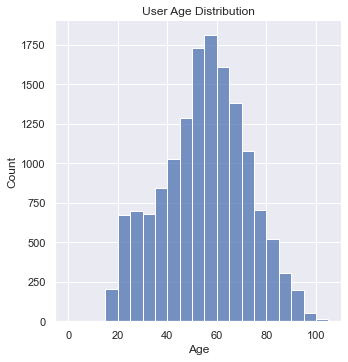

In [106]:
bins = np.arange(0, profile_complete.age.max()+5, 5)
sb.displot(profile_complete.age, bins=bins)
sb.despine() # Setting theme for all plots
plt.title('User Age Distribution')
plt.xlabel('Age');

Customer age roughly followed a normal distribution and averaged 54 years. The youngest customer was 18 years old, and the oldest was 101 years old. 

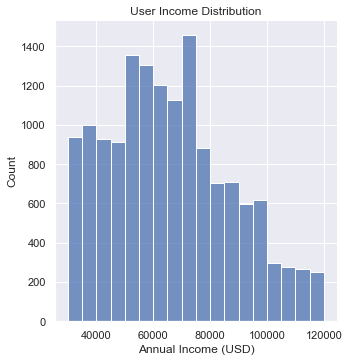

In [107]:
bins = np.arange(30000, profile_complete.income.max()+5000, 5000)
sb.displot(profile_complete.income, bins=bins)
plt.title('User Income Distribution')
plt.xlabel('Annual Income (USD)');

Looking at income bands of USD 5,000, most customers earned between USD 50,000 and USD 75,000. Beyond USD 75,000 annual salary, the number of users per salary band gradually decreased. Quite a few users belonged to the low-income group with an annual salary of USD 30,000 to USD 50,000. 

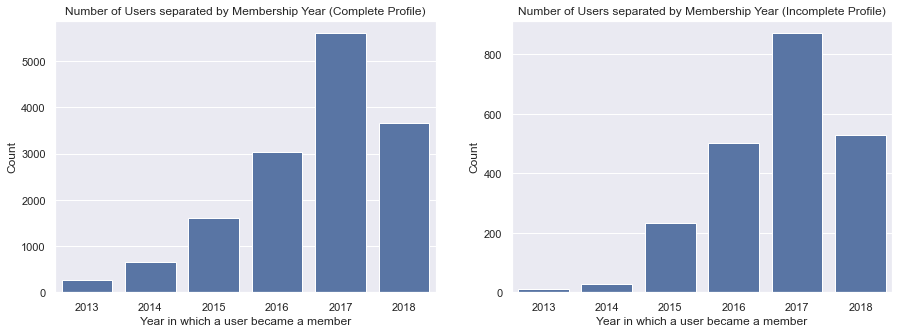

In [108]:
base_color = sb.color_palette()[0]
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
sb.countplot(data=profile_complete, x='member_year', color=base_color)
plt.title('Number of Users separated by Membership Year (Complete Profile)')
plt.xlabel('Year in which a user became a member')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sb.countplot(data=profile_incomplete, x='member_year', color=base_color)
plt.title('Number of Users separated by Membership Year (Incomplete Profile)')
plt.xlabel('Year in which a user became a member')
plt.ylabel('Count');

Most users became members of the Starbucks loyalty program in 2017. Between 2013 and 2016, the number of members signing up increased steadily. In 2018, Starbucks experienced a decrease in new memberships. This pattern holds for both user groups, with complete and incomplete profiles.

In [73]:
profile_complete.groupby('gender')['age'].mean()

gender
F    57.544950
M    52.116690
O    54.400943
Name: age, dtype: float64

Women were the oldest user group, averaging 57 years of age. The average male user was 5 years younger and the average other user 54 years.

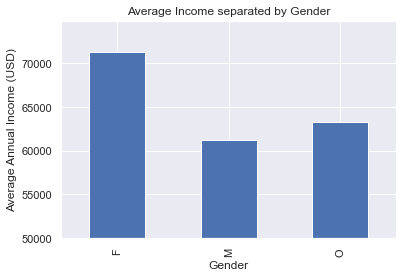

In [109]:
profile_complete.groupby('gender')['income'].mean().plot(kind='bar')
plt.ylim(50000, None)
plt.title('Average Income separated by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Annual Income (USD)');

In [75]:
profile_complete.groupby('gender')['income'].mean()

gender
F    71306.412139
M    61194.601603
O    63287.735849
Name: income, dtype: float64

Women earned more than USD 70,000 per year on average. Men, on the other hand, earned USD 10,000 less. The remaining users had an annual income of around USD 63,000.

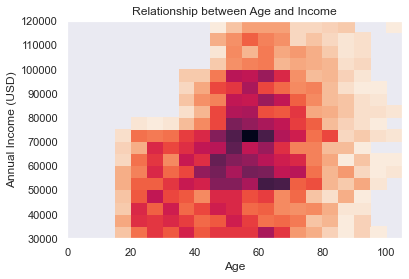

In [110]:
sample_size = 0.3 # If you choose 1 the entire dataset will be displayed
sample = profile_complete.sample(int(sample_size*profile_complete.shape[0]))
x_bins = np.arange(0, sample.age.max()+5, 5)
y_bins = np.arange(30000, sample.income.max()+5000, 5000)
plt.hist2d(x=sample['age'], y=sample['income'], cmin=0.5, cmap='rocket_r', bins=[x_bins, y_bins])
plt.title('Relationship between Age and Income')
plt.xlabel('Age')
plt.ylabel('Annual Income (USD)');

There is no strong relationship between age and income. Users younger than 35 did not surpass the USD 80,000 salary threshold. Older users (70+ years) displayed incomes across the entire spectrum. There was a large cluster of users between 40 and 70 earning between USD 50,000 and USD 90,000.

**``portfolio_clean``**

In [77]:
portfolio_clean[portfolio_clean.offer_type == 'bogo']

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,1,1,1,1,0
1,10,10,5,bogo,2,1,1,1,1
3,5,5,7,bogo,4,1,1,0,1
8,5,5,5,bogo,9,1,1,1,1


In [78]:
portfolio_clean[portfolio_clean.offer_type == 'discount']

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
4,5,20,10,discount,5,1,0,0,1
5,3,7,7,discount,6,1,1,1,1
6,2,10,10,discount,7,1,1,1,1
9,2,10,7,discount,10,1,1,0,1


In [79]:
portfolio_clean[portfolio_clean.offer_type == 'informational']

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
2,0,0,4,informational,3,1,1,0,1
7,0,0,3,informational,8,1,1,1,0


There were three types of offers: bogos (buy one get one free), discounts and informational offers.
* By definition, a bogo always yielded the same amount that the user had previously invested (*difficulty*). They lasted either 5 or 7 days.
* Discount offers were presented to the customer for a longer time period (7 or 10 days) and provided lower rewards compared to bogos. 
* Informational offers did not reward users and only had a duration of 3 to 4 days.
* All offer types were sent out via email. With the exception of offer 5, which is the one with the highest difficulty, all offers were offered as a mobile version. The social and web channels were used more infrequently.

By combining different offer characteristics - duration, upfront investment, reward, communication channel - a total of ten offers was created.

**``transcript_clean``**

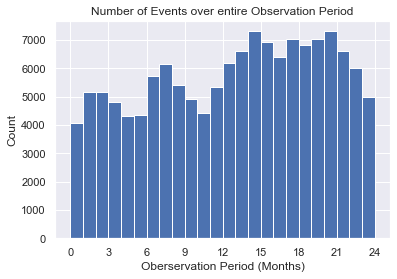

In [111]:
bins = np.arange(0, transcript_clean.time.max()+30, 30) # Monthly period
transcript_clean[transcript_clean.event == 'transaction']['time'].hist(bins=bins)
plt.title('Number of Events over entire Observation Period')
plt.xlabel('Oberservation Period (Months)')
plt.ylabel('Count')
ticks = np.arange(0, transcript_clean.time.max()+30, 90)
labels = ['{}'.format(int(v/30)) for v in ticks]
plt.xticks(ticks, labels);

In [81]:
transcript_clean[transcript_clean.time < 714 / 2]['event'].count() 

135224

In [82]:
transcript_clean[transcript_clean.time >= 714 / 2]['event'].count() 

171310

Events were recorded over a two-year period. In the first year, 135,224 events took place, compared to 171,310 events in the second year.

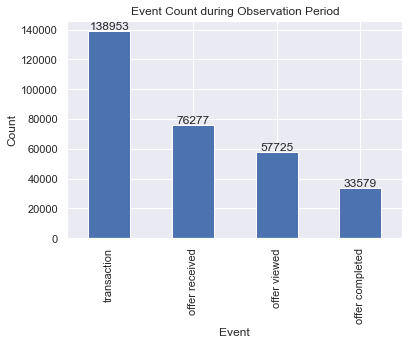

In [112]:
event_count = transcript_clean.event.value_counts()
event_count.plot(kind='bar')
plt.title('Event Count during Observation Period')
plt.xlabel('Event')
plt.ylabel('Count')
for i in np.arange(4):
    plt.text(x=i, y=event_count[i]+1000, s='{}'.format(event_count[i]), ha='center');

In [84]:
event_count[2] / event_count[1], event_count[3] / event_count[1]

(0.7567812053436815, 0.4402244451145168)

In [85]:
event_count[0] / transcript_clean.time.max(), event_count[0] / profile_clean.shape[0]

(194.61204481792717, 8.173705882352941)

During the observation period, users spent money on Starbucks products nearly 140,000 times. This represents a daily rate of 195 transactions and about 8 transactions per user. More than 76,000 offers were sent, of which 76% were viewed and 44% completed.

In [86]:
np.log10(transcript_clean.amount.describe())

count    5.142868
mean     1.106441
std      1.480733
min     -1.301030
25%      0.444045
50%      0.948902
75%      1.256958
max      3.026239
Name: amount, dtype: float64

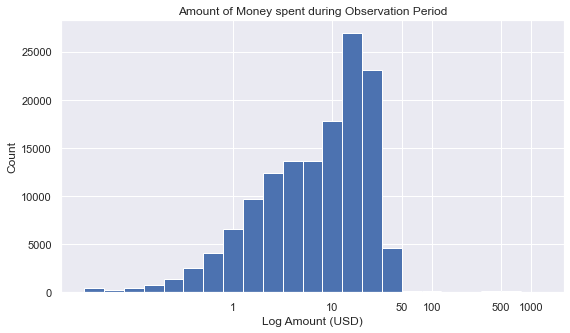

In [113]:
plt.figure(figsize=(9,5))
bins = 10 ** np.arange(-1.5, 3+0.2, 0.2)
transcript_clean[transcript_clean.event == 'transaction']['amount'].hist(bins=bins)

plt.title('Amount of Money spent during Observation Period')
plt.xlabel('Log Amount (USD)')
plt.ylabel('Count')
plt.xscale('log')
ticks = [1, 10, 50, 100, 500, 1000]
labels = ['{}'.format(v) for v in ticks]
plt.xticks(ticks, labels);

In terms of spending per transaction, a logarithmic distribution emerges. Most users purchased products between USD 10 and USD 25. Only very few users spent more than USD 50.

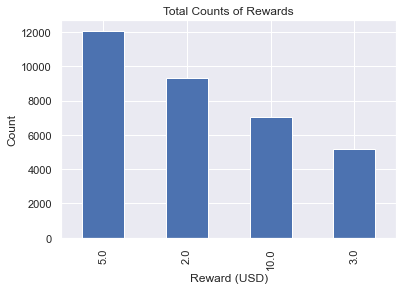

In [114]:
transcript_clean[transcript_clean.reward.notnull()]['reward'].value_counts().plot(kind='bar')
plt.title('Total Counts of Rewards')
plt.xlabel('Reward (USD)')
plt.ylabel('Count');

In terms of absolute numbers the USD 5 reward was handed out most of the time, followed by USD 2, USD 10 and finally USD 3 rewards (in descending order).

Since both the offer received and offer completed events were recorded, I can calculate a success rate per offer.

In [89]:
offers_sent = transcript_clean[transcript_clean.event == 'offer received']['offer_id'].value_counts()
rewards = transcript_clean[transcript_clean.reward.notnull()]['offer_id'].value_counts() / offers_sent

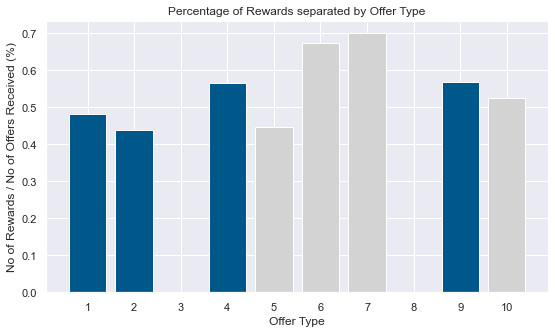

In [125]:
plt.figure(figsize=(9,5))
plt.bar(rewards.index, rewards.values, color=['#00578a', '#00578a', 'white', '#00578a', 'lightgrey', 'lightgrey', 'lightgrey', 'white', '#00578a', 'lightgrey'])
plt.title('Percentage of Rewards separated by Offer Type')
plt.xlabel('Offer Type')
plt.ylabel('No of Rewards / No of Offers Received (%)')
ticks = np.arange(1, 11)
labels = ['{}'.format(v) for v in ticks]
plt.xticks(ticks, labels);

Bogos are indicated by blue bars, while discounts are shown as gray. Since there were no rewards associated with the information offers, no bars are shown for offers 3 and 8. Offers 6 and 7 have the highest success rates. For 70% of these offers, both events, offer received and offer completed, were logged. Although both offers were discounts, there is no clear pattern to conclude that discounts were preferred over bogos. Offers 2 and 5 have the lowest success rates and were bogo and discount, respectively.

Although this analysis gives us an initial indication of the success of an offer, this generic and broad approach has some shortcomings:
* A user might have received a reward but never looked at the offer until after the purchase.
* A user might have received a reward but never looked at the offer itself.
* A user might have received an offer twice, but only purchased it once or not at all.
* Informational offers would never be considered a success.

Therefore, in the next section, I will further preprocess the datasets. I will first define successful offers and then assign each user-offer pair their category. The ``profile_clean`` dataframe will increase by ten columns each representing one offer. This will be the foundation for generating models afterwards.

***

<a id="preprocess"></a>
## Preprocessing

### Defining a successful offer

* A user cannot view an offer he/she has not received.
* If a user has received a specific offer more than once and the offer was completed successfully at least once, the user-offer pair is defined as success.
* Completing an offer is defined as purchasing the offer in time to receive a reward. A purchase made when the offer period has already passed is not identified as a successful purchase.
* A successful purchase is defined as:
  * For informational offers (3 and 8):
    * NaN - A user who has not received an informational offer.
    * 0 - A user who has received an informational offer but did not view it.
    * 1 - A user who has received and viewed an informational offer. **SUCCESS**

  * For discount (5, 6, 7, 10) and bogo (1, 2, 4, 9) offers:
    * NaN - A user who has not received a discount or bogo offer.
    * 0 - A user who has received a discount or bogo offer, but did not view or complete it.
    * 0 - A user who has received and viewed a discount or bogo offer, but did not complete a purchase.
    * 0 - A user who has received a discount or bogo offer and completed a purchase, but did not view it. 
    * 0 - A user who has received a discount or bogo offer and completed a purchase, but did only view it after completing the purchase.
    * 1 - A user who has received, viewed and completed a purchase for a discount or bogo offer. **SUCCESS**

### Creating a new dataframe ``user_offer_df``
The new dataframe contains the information from profile_clean and an entry for each offer about its success for a particular user. Here, I will use profile_clean in its entirety since the output will be required for all users - regardless whether personal data is missing.

In [130]:
def user_offer_dict(user_id):
    """
    Identify whether an offer was successful (1) or not (0) for a given user id.
    
    INPUT:
    user_id - id for a specific user
    
    OUTPUT:
    user_offer_dict - A dictionary with offer ids as keys and 0/1 as values
    """
    
    transactions = transcript_clean[transcript_clean.person_id == user_id]
    # Offers a user has received
    received = list(transactions[transactions.event == 'offer received']['offer_id'].values)

    user_offer_dict = {1.:np.nan, 2.:np.nan, 3.:np.nan, 4.:np.nan, 5.:np.nan, 
                       6.:np.nan, 7.:np.nan, 8.:np.nan, 9.:np.nan, 10.:np.nan}
    
    for offer in received:
        # Put all events associated with that offer id into a list
        event_order = transactions[transactions.offer_id == offer]['event'].values.tolist()
        
        # Informational offers
        if (offer == 3. or offer == 8.) and (event_order.count('offer viewed') > 0):
            user_offer_dict[offer] = 1
        
        # Discount and bogo offers
        elif (len(event_order) > 2) and ('offer completed' in event_order) and ('offer viewed' in event_order):
            if (event_order.index('offer completed') - event_order.index('offer viewed') >= 0):
                user_offer_dict[offer] = 1
            else:
                user_offer_dict[offer] = 0
        
        else:
            user_offer_dict[offer] = 0
            
    return user_offer_dict

In [131]:
# All users in Starbucks database
users = profile_clean.person_id.values

# All offers 
offers = np.arange(1.0, 11.0)

In [133]:
# Store profile_clean copy in new df
user_offer_df = profile_clean.copy()

# Go through every user and add the user-offer pair values to df 
for i, user in enumerate(users):
    user_dict = user_offer_dict(user)
    user_idx = user_offer_df[user_offer_df.person_id == user].index
    user_offer_df.loc[user_idx, user_dict.keys()] = user_dict.values()
    update_progress(i / len(users))

Progress: [####################] 100.0%


In [135]:
user_offer_df

,gender,age,income,person_id,member_year,member_month,member_day,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
0,None,NaN,NaN,1,2017,2,12,NaN,NaN,NaN,NaN,0.0,1.0,1.0,NaN,NaN,0.0
1,F,55.0,112000.0,2,2017,7,15,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,None,NaN,NaN,3,2018,7,12,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,NaN,NaN
3,F,75.0,100000.0,4,2017,5,9,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,0.0,NaN
4,None,NaN,NaN,5,2017,8,4,NaN,NaN,1.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,F,45.0,54000.0,16996,2018,6,4,NaN,0.0,NaN,NaN,NaN,0.0,NaN,1.0,NaN,NaN
16996,M,61.0,72000.0,16997,2018,7,13,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN
16997,M,49.0,73000.0,16998,2017,1,26,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1.0,NaN,NaN
16998,F,83.0,50000.0,16999,2016,3,7,0.0,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [150]:
# Blog post illustration
user_offer_df_sample = user_offer_df.sample(10).rename(columns={'gender':'Gender', 'age':'Age', 'income':'Income', 
                                                                'person_id':'User ID', 'member_year':'Year', 
                                                                'member_month':'Month', 'member_day':'Day',
                                                                1.:'1', 2.:'2', 3.:'3', 4.:'4', 5.:'5', 
                                                                6.:'6', 7.:'7', 8.:'8', 9.:'9', 10.:'10'})

In [151]:
# Blog post illustration
user_offer_df_sample

,Gender,Age,Income,User ID,Year,Month,Day,1,2,3,4,5,6,7,8,9,10
14746,M,51.0,35000.0,14747,2017,10,5,0.0,NaN,0.0,0.0,0.0,NaN,1.0,NaN,NaN,NaN
2229,M,20.0,39000.0,2230,2017,12,4,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,0.0
7174,F,22.0,39000.0,7175,2017,12,21,0.0,NaN,NaN,0.0,NaN,1.0,NaN,NaN,1.0,NaN
7302,M,51.0,37000.0,7303,2017,6,9,1.0,NaN,NaN,NaN,0.0,NaN,1.0,1.0,NaN,0.0
13386,F,51.0,118000.0,13387,2016,5,20,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
15951,M,47.0,38000.0,15952,2015,2,15,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,0.0,NaN
16085,O,66.0,40000.0,16086,2017,12,21,1.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0
900,None,NaN,NaN,901,2017,9,5,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
13712,F,22.0,61000.0,13713,2016,8,12,NaN,0.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN
11785,M,60.0,74000.0,11786,2017,8,16,NaN,0.0,NaN,NaN,NaN,NaN,0.0,1.0,NaN,0.0


***

<a id="model"></a>

## Modeling and Evaluation

Before building any models, let's summarize what has been done so far. First, I evaluated each dataframe from a quality and tidiness perspective and cleaned up some issues accordingly. Next, I visually examined the datasets to better understand the content itself. I also made an initial approach to calculating the success rate for each offer type. Finally, I generated a new dataframe and assigned one of two categories (0 or 1) to each user-offer pair, or a NaN if there was no interaction.

In general, users can be split into three groups:
1. Existing users with personal data (Model 1)
2. Existing users without personal data (Model 2)
3. Completely new users (Model 3)

For each I chose a different approach to make a recommendation on which offers to send to which user.

<a id="model1"></a>
### Model 1 - Classifier Model

Now that I have assigned a label to each user-offer pair, I can create a supervised learning model. The goal of this model is to predict whether a user will respond positively to an offer or not. Customers are ultimately sent only offers that are predicted to have a successful outcome.

In [158]:
# First user group for which we have age, gender and income data
users1 = profile_complete.person_id.values

In [159]:
# Percentage of labels per offer
labels_per_offer = user_offer_df[user_offer_df.gender.notnull()][offers].count() / profile_complete.shape[0]
labels_per_offer

1.0     0.375312
2.0     0.371737
3.0     0.372614
4.0     0.373828
5.0     0.376931
6.0     0.371467
7.0     0.373963
8.0     0.372142
9.0     0.367285
10.0    0.369646
dtype: float64

In [160]:
labels_per_offer.mean()

0.37249241146711637

In [161]:
# Average number of offers a user received
user_offer_df[offers].count(axis=1).mean()

3.7228235294117646

Since I predict more than one target variable for each user, a MultiOutputClassifier would be a natural choice. However, there is not a single customer who has received all offers. Each customer has received an average of only 3.7 offers. For the remaining offers, we simply don't know yet whether a user will respond positively. Therefore, this approach will not work. For this reason, I decided to look at each offer individually and repeat the following steps:

1. Create a subset of user_offer_df containing only users for which a label exists
2. Transform categorical columns into dummies
3. Build a trained classifier
   * Define the independent and dependent (target) variables
   * Split the subset into training and test dataset
   * Fit the classifier on the training dataset
4. Make predictions on the test dataset and evaluate these results against the actual values

In [162]:
def get_offer_df(col):
    """
    Create subset from user_offer_df for one offer type.
    
    INPUT:
    col - one out of 10 offer types
    
    OUTPUT:
    sub_df - df containing no missing values for the selected offer type
    """
    
    all_offers = np.arange(1., 11.).tolist()
    all_offers.remove(col)
    
    sub_df = user_offer_df[user_offer_df[col].notnull()]
    sub_df = sub_df.drop(all_offers, axis=1)
    sub_df[col] = sub_df[col].astype(int)
    sub_df = sub_df.dropna(axis=0)
    
    return sub_df

In [163]:
def get_dummies_df(df, cat_cols=['gender']):
    """
    Create dummy variables for categorical columns.
    
    INPUT:
    df - dataframe to be transformed
    cat_cols - categorical columns
    
    OUTPUT:
    df - transformed dataframe
    """

    for col in cat_cols:
        try:
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)
        except:
            continue

    return df

**Classifier** 

I used a RandomForestClassifier. My decision is based on experience from other projects. For similar classification tasks I reached the best performance with random forests. Moreover, random forests are already very good at classification and usually have reasonable default hyperparameters.

In [164]:
def classifier_model(df, target_col, test_size=0.2, classifier=RandomForestClassifier()):
    """
    Create a classifier model fitted on a given training dataset.
    
    INPUT:
    df - dataframe containing all entries
    target_col - target variable
    test_size - size of test dataset (default: 20%)
    classifier - estimator (default: RandomForestClassifier)
    
    OUTPUT:
    clf - trained classifier
    X_test - test dataset with independent variables
    Y_test - test dataset with dependent (target) variable
    """
    
    X = df.drop(['person_id', target_col], axis=1)
    Y = df[target_col]
    
    # Split X and Y into train and test datasets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    
    # Fit the classifier on the training dataset
    clf = classifier
    clf.fit(X_train, Y_train)
    
    return clf, X_test, Y_test

**Performance metrics** 

To evaluate the performance of my model, I will use the Accuracy, Precision, Recall and F1 Score.
* Accuracy: Number of correct predictions / Number of data points — How many correct predictions do I make in total?
* Precision: True positives / (true positives + false positives) — What is my type I error rate? Put another way: For how many users do I correctly predict a success?
* Recall: True positives / (true positives + false negatives) — What is my type II error rate? Put another way: For how many users do I miss a success?
* F1 Score: 2 * (Accuracy * Recall) / (Accuracy + Recall) — A balance between accuracy and recall.

For most situations, the type I error rate is considered more critical, meaning it should be kept low. In the Starbucks example, I would argue that the recall may be more important, as presenting a user with an offer they don't like may be less harmful than not showing a user an offer at all (lost revenue).

In [165]:
def evaluate_model(clf, X_test, Y_test):
    """
    Make predictions on test dataset and calculate performance metrics.
    
    INPUT:
    clf - trained classifier
    X_test - test dataset with independent variables
    Y_test - test dataset with dependent (target) variable 
    
    OUTPUT:
    scores - dataframe containing accuracy, precision, recall, and f1 scores for one offer
    """
    
    # Predict outcomes on test dataset
    Y_pred = clf.predict(X_test)
    Y_pred_ = pd.DataFrame(Y_pred)
    Y_test_ = pd.DataFrame(Y_test)
    
    # Print out the classification report
    print(classification_report(Y_test_, Y_pred_) + '\n')
    
    # Store scores in a dataframe
    scores_dict = {'accuracy': [accuracy_score(Y_test, Y_pred)],
                   'precision': [precision_score(Y_test, Y_pred)],
                   'recall': [recall_score(Y_test, Y_pred)],
                   'f1_score': [f1_score(Y_test, Y_pred)]}
    
    scores = pd.DataFrame(scores_dict)
    
    return scores

In [166]:
def get_scores_df(classifier=RandomForestClassifier()):
    """
    Store performance metrics in separate dataframe for all offers.
    
    INPUT:
    classifier - estimator (default: RandomForestClassifier)
    
    OUTPUT:
    scores_df - dataframe containing accuracy, precision, recall and f1 scores for all offers
    """
    
    scores_df = pd.DataFrame()
    
    for offer in offers:
        # Create classifier for every offer
        df = get_offer_df(col=offer)
        df = get_dummies_df(df)
        clf, X_test, Y_test = classifier_model(df=df, target_col=offer, classifier=classifier)
        
        print(offer)
        tmp = evaluate_model(clf, X_test, Y_test)
        tmp['offer'] = offer
        scores_df = pd.concat([scores_df, tmp], axis=0, ignore_index=True)
    
    scores_df['model'] = str(classifier)
    
    return scores_df

In [167]:
# Classification report for all offers with a RandomForestClassifier
scores_df = get_scores_df()

1.0
              precision    recall  f1-score   support

           0       0.69      0.68      0.69       701
           1       0.47      0.47      0.47       412

    accuracy                           0.61      1113
   macro avg       0.58      0.58      0.58      1113
weighted avg       0.61      0.61      0.61      1113


2.0
              precision    recall  f1-score   support

           0       0.70      0.75      0.72       621
           1       0.64      0.59      0.61       482

    accuracy                           0.68      1103
   macro avg       0.67      0.67      0.67      1103
weighted avg       0.68      0.68      0.68      1103


3.0
              precision    recall  f1-score   support

           0       0.56      0.52      0.54       492
           1       0.64      0.68      0.66       613

    accuracy                           0.61      1105
   macro avg       0.60      0.60      0.60      1105
weighted avg       0.60      0.61      0.61      1105


4.0


In [168]:
# Performance metrics for all offers
scores_df

,accuracy,precision,recall,f1_score,offer,model
0,0.606469,0.468750,0.473301,0.471014,1.0,RandomForestClassifier()
1,0.677244,0.643182,0.587137,0.613883,2.0,RandomForestClassifier()
2,0.607240,0.637060,0.678630,0.657188,3.0,RandomForestClassifier()
3,0.660956,0.451456,0.261236,0.330961,4.0,RandomForestClassifier()
4,0.779964,0.352113,0.111111,0.168919,5.0,RandomForestClassifier()
5,0.675136,0.724390,0.818182,0.768435,6.0,RandomForestClassifier()
6,0.697926,0.738178,0.855615,0.792570,7.0,RandomForestClassifier()
7,0.904891,0.908098,0.996008,0.950024,8.0,RandomForestClassifier()
8,0.608815,0.648148,0.639535,0.643813,9.0,RandomForestClassifier()
9,0.670620,0.538462,0.314815,0.397329,10.0,RandomForestClassifier()


In [191]:
# Blog post illustration
scores_ill = scores_df.rename(columns={'accuracy':'Accuracy [%]', 'precision':'Precision [%]', 'recall':'Recall [%]', 
                                       'f1_score':'F1 Score [%]', 'offer': 'Offer ID', 'model':'Classifier'})
for col in ['Accuracy [%]', 'Precision [%]', 'Recall [%]', 'F1 Score [%]']:
    scores_ill[col] = scores_ill[col] * 100
    scores_ill[col] = scores_ill[col].astype(int)

scores_ill['Offer ID'] = scores_ill['Offer ID'].astype(int)

In [192]:
scores_ill.style.set_properties(**{'text-align': 'center'}).set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])])

,Accuracy [%],Precision [%],Recall [%],F1 Score [%],Offer ID,Classifier
0,60,46,47,47,1,RandomForestClassifier()
1,67,64,58,61,2,RandomForestClassifier()
2,60,63,67,65,3,RandomForestClassifier()
3,66,45,26,33,4,RandomForestClassifier()
4,77,35,11,16,5,RandomForestClassifier()
5,67,72,81,76,6,RandomForestClassifier()
6,69,73,85,79,7,RandomForestClassifier()
7,90,90,99,95,8,RandomForestClassifier()
8,60,64,63,64,9,RandomForestClassifier()
9,67,53,31,39,10,RandomForestClassifier()


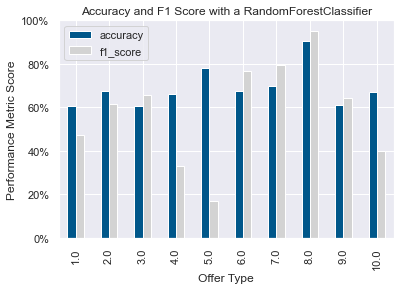

In [169]:
# Visualize accuracy and f1 score for all offers
scores_df[['accuracy', 'f1_score']].plot(kind='bar', color=['#00578a', 'lightgrey'])
plt.xticks(ticks=np.arange(0, 10), labels=offers)
y_ticks = np.arange(0, 1.1, 0.2)
y_labels = ['{}%'.format(int(v*100)) for v in y_ticks]
plt.yticks(ticks=y_ticks, labels=y_labels)
plt.title('Accuracy and F1 Score with a RandomForestClassifier')
plt.xlabel('Offer Type')
plt.ylabel('Performance Metric Score'); 

**Results**
* Informational offers (3 and 8): A success for offer 8 can be predicted with a high degree of certainty. This is mainly due to the fact that offer 8 is very popular. Less than 10% of the labeled data indicate an unsuccessful offer.
* Bogos (1, 2, 4, and 9): The overall accuracy varies between 60% and 67%. For offers 1 and 4, this impression shifts when evaluating the remaining metrics. A success for offer 4 can only be predicted with 33% confidence. The recall rate is even worse. This can also be associated with a skewed dataset - only one third of customers responded positively to offer 4.
* Discounts (5, 6, 7 and 10): The classifier performs well on offers 6 and 7 - both contain about two thirds of successful labels compared to unsuccessful labels. Offer 5 displays high accuracy, but fails to predict positive labels, as indicated by the low F1 score.

The final step is to make predictions for all users and all offers. Given a user ID, we can now return a list of offers that are predicted to succeed.

In [170]:
# All user profiles 
X_complete = user_offer_df[user_offer_df.gender.notnull()].drop(offers, axis=1)
predictions = X_complete.copy()

# All user id's
user_ids = X_complete['person_id'].values

# Make predictions for all users in profile_complete
for offer in offers:
    df = get_offer_df(col=offer)
    df = get_dummies_df(df)
    clf, X_test, Y_test = classifier_model(df=df, target_col=offer)
        
    Y_pred = clf.predict(get_dummies_df(X_complete).drop('person_id', axis=1))
    predictions[offer] = Y_pred

In [171]:
def recommender_clf(user_id, predictions):
    """
    Recommend offers to a specific user based on their profile.
    
    INPUT:
    user_id - user for whom we'd like to make recommendations
    
    OUTPUT:
    recs - list of offers the user should be presented with
    """
    
    recs = []
    
    for offer in offers:
        # Check whether offer will be a predicted success for this user
        if predictions[(predictions.person_id == user_id)][offer].values == 1:
            recs.append(offer)
        
    return recs

In [172]:
predictions

,gender,age,income,person_id,member_year,member_month,member_day,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
1,F,55.0,112000.0,2,2017,7,15,0,1,0,0,0,1,1,1,0,0
3,F,75.0,100000.0,4,2017,5,9,1,1,0,1,0,1,1,1,0,0
5,M,68.0,70000.0,6,2018,4,26,0,0,0,1,0,0,1,1,0,0
8,M,65.0,53000.0,9,2018,2,9,0,0,1,1,0,1,1,1,1,1
12,M,58.0,51000.0,13,2017,11,11,0,0,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,F,45.0,54000.0,16996,2018,6,4,0,0,1,0,0,1,1,1,0,0
16996,M,61.0,72000.0,16997,2018,7,13,0,0,0,0,0,0,0,1,0,0
16997,M,49.0,73000.0,16998,2017,1,26,1,1,1,0,0,1,1,1,1,0
16998,F,83.0,50000.0,16999,2016,3,7,0,1,1,0,0,1,1,1,1,0


In [173]:
# Example: Predictions for user 4
recommender_clf(user_id=4, predictions=predictions)

[1.0, 2.0, 4.0, 6.0, 7.0, 8.0]

In [193]:
# Actual successes for user 4
user_offer_df[user_offer_df.person_id == 4]

,gender,age,income,person_id,member_year,member_month,member_day,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
3,F,75.0,100000.0,4,2017,5,9,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,0.0,NaN


***
<a id="model2"></a>
### Model 2 - Collaborative Filtering Recommendation System

The idea behind a collaborative filtering system is that nothing actually needs to be known about a user or the product (called an item). Knowing how a user has interacted with an item (in the form of rating a movie, clicking a link, buying a product) is enough to predict future interactions. For reasons I explained earlier, this is particularly interesting for users with incomplete profiles. The key to making this work are latent features. A latent feature is not directly observed in our data, rather, we infer it based on the successfulness of an offer for a specific user.

One algorithm based on this idea is FunkSVD, where SVD stands for Singular Value Decomposition

In [194]:
# Second user group for which we don't have age, gender and income data
users2 = profile_incomplete.person_id.values

In [195]:
# User_offer_df subset of only interactions (aka user-offer pairs)
user_offer_sub = user_offer_df.drop(['gender', 'age', 'income', 'member_year', 'member_month', 'member_day'], axis=1)

In [196]:
user_offer_sub = user_offer_sub.set_index('person_id')
user_offer_sub

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
person_id,,,,,,,,,,
1,NaN,NaN,NaN,NaN,0.0,1.0,1.0,NaN,NaN,0.0
2,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,NaN,NaN
4,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,0.0,NaN
5,NaN,NaN,1.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
16996,NaN,0.0,NaN,NaN,NaN,0.0,NaN,1.0,NaN,NaN
16997,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN
16998,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1.0,NaN,NaN


**How does FunkSVD work?**
1. Split the subset into training and test dataset — If a user or offer is not present in the training dataset, we won’t be able to make predictions for them. This problem is known as Cold Start Problem. Model 3 will address users falling into that category. Since it neither makes sense to filter by user, offer or success, I will therefore randomly sample from the interactions dataset.
2. Create a user-item-matrix — The work I put into model 1 will come in handy for this step.
   * Each row representing one user 
   * Each column representing one item (item = offer)
   * Each cell representing the user-item success
3. FunkSVD
   * Initialize the u and v matrices randomly
     * u-matrix (user matrix) with a size of n users x k latent features
     * v-matrix (offer matrix) with a size of k latent features x n offers
   * Iterate through the user-offer-matrix
     * If a user-item pair exists (0 or 1), calculate the predicted success which is the dot product between the respective user row from u and the respective offer column from v
     * Calculate the difference between the actual value and the predicted success which represents the error
     * Minimize the error using gradient descent and update u and v accordingly
   * Repeat this process for several iterations
4. Make predictions using the final u and v matrices and evaluate these results against the actual values in the test dataset

In [197]:
def create_train_test(df=user_offer_sub, test_size=0.2):
    ''' 
    Create a training and test dataset.
    
    INPUT:
    df - interactions dataframe to split into train and test
    test_size - no of rows in test dataset
    
    OUTPUT:
    train_df - training dataset (unstacked)
    test_df - test dataset (unstacked)
    train_stacked - training dataset (stacked)
    test_stacked - test dataset (stacked)
    '''
    
    df_stacked = df.stack().to_frame().reset_index().rename(columns={'level_0':'person_id', 'level_1':'offer_id', 0:'success'})
    
    test_stacked = df_stacked.sample(int(df_stacked.shape[0]*test_size), random_state=1)
    train_stacked = df_stacked.drop(test_stacked.index.values, axis=0)
    
    test_df = test_stacked.groupby(['person_id', 'offer_id'])['success'].max().unstack()
    train_df = train_stacked.groupby(['person_id', 'offer_id'])['success'].max().unstack()
    
    return train_df, test_df, train_stacked, test_stacked

In [198]:
train_df, test_df, train_stacked, test_stacked = create_train_test()

In [199]:
train_users = train_df.index
test_users = test_df.index

In [200]:
len(np.setdiff1d(test_users, train_users))

143

There are 143 unique users in the test dataset for whom I cannot make predictions. This user group represents new users without any interactions.

In [201]:
success_matrix = np.array(train_df)

In [221]:
def FunkSVD(success_mat=success_matrix, latent_features=5, learning_rate=0.001, iters=100):
    '''
    Perform matrix factorization using a basic form of FunkSVD with no regularization.
    
    INPUT:
    success_mat - matrix with users as rows, offers as columns, and non-/successes as values
    latent_features - no of latent features 
    learning_rate 
    iters - no of iterations
    
    OUTPUT:
    user_mat - a user by latent feature matrix
    offer_mat - a latent feature by offer matrix
    '''
    
    n_users = success_mat.shape[0] 
    n_offers = success_mat.shape[1] 
    num_success = np.count_nonzero(~np.isnan(success_mat))
    
    # initialize the user and offer matrices with random values
    user_mat = np.random.rand(n_users, latent_features)  
    offer_mat = np.random.rand(latent_features, n_offers)
    
    # initialize summed squared error (sse) at 0 for first iteration
    sse_accum = 0
    
    # To follow the optimization process visually uncomment the print statements
    print("Optimization Statistics")
    print("Iterations | Mean Squared Error ")
    
    for iteration in range(iters):
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-offer pair
        for i in range(n_users):
            for j in range(n_offers):
                # if the pair exists
                if (success_mat[i, j] == 0) | (success_mat[i, j] == 1):
                    # compute the error as the actual minus the dot product of the user and offer matrices
                    error = success_mat[i, j] - np.dot(user_mat[i, :], offer_mat[:, j])
                    # Keep track of the total sum of squared errors for the matrix
                    sse_accum += error ** 2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += 2 * learning_rate * error * offer_mat[k, j]
                        offer_mat[k, j] += 2 * learning_rate * error * user_mat[i, k]
        
        print(iteration, sse_accum/num_success)
        
    return user_mat, offer_mat

In [222]:
user_mat, offer_mat = FunkSVD()

Optimization Statistics
Iterations | Mean Squared Error 
0 0.2724333103500771
1 0.22903055039041678
2 0.22697422983374774
3 0.2263860727984519
4 0.22607609728398748
5 0.22581958831220886
6 0.225573794909578
7 0.22533047885203206
8 0.22508801172382784
9 0.22484605485387854
10 0.22460453083981896
11 0.22436341915807367
12 0.22412271326456543
13 0.22388241065632825
14 0.22364251020138182
15 0.22340301128901108
16 0.22316391351801332
17 0.22292521657126022
18 0.2226869201627347
19 0.2224490240145113
20 0.22221152784672715
21 0.22197443137313833
22 0.22173773429914753
23 0.22150143632096544
24 0.22126553712522556
25 0.22103003638881508
26 0.22079493377882523
27 0.22056022895252847
28 0.2203259215573634
29 0.22009201123095365
30 0.219858497601109
31 0.21962538028585218
32 0.2193926588933988
33 0.21916033302220905
34 0.21892840226096985
35 0.21869686618862252
36 0.21846572437437134
37 0.21823497637768693
38 0.21800462174833452
39 0.2177746600263695
40 0.2175450907421705
41 0.21731591341642628

In [223]:
def predict_success(user_mat, offer_mat, user_id, offer_id):
    """
    Predict the success of an offer.
    
    INPUT:
    user_mat - a user by latent feature matrix
    offer_mat - a latent feature by offer matrix
    
    OUTPUT:
    pred - prediction for a given user id and offer if
    """
    
    # Create series of users and movies in the right order
    user_ids = np.array(train_df.index)
    offer_ids = np.array(train_df.columns)
    
    # User row and offer column
    user_row = np.where(user_ids == user_id)[0][0]
    offer_col = np.where(offer_ids == offer_id)[0][0]
    
    # Take dot product of that row and column in U and V to make prediction
    pred = np.dot(user_mat[user_row, :], offer_mat[:, offer_col])
    
    return pred

In [243]:
def validate_predictions(df_stacked, user_mat, offer_mat):
    """
    Validate predictions on test dataset.
    
    INPUT:
    df_stacked - user_offer_matrix in stacked form
    user_mat - a user by latent feature matrix
    offer_mat - a latent feature by offer matrix
    
    OUTPUT:
    rmse - root mean squared error
    perc_rated - percentage of rated users
    preds - predictions
    acts - actual values
    """
    
    test_users = np.array(df_stacked['person_id'])
    test_offers = np.array(df_stacked['offer_id'])
    test_success = np.array(df_stacked['success'])
    
    # sse - summed squared error, rated - number of user-offer pairs for which a prediction is possible
    sse, predicted = 0, 0
    preds, acts = [], []
    
    for idx in range(len(test_users)):
        try:
            pred = predict_success(user_mat, offer_mat, test_users[idx], test_offers[idx])
            sse += (pred - test_success[idx]) ** 2
            predicted += 1
            preds.append(np.round(pred))
            acts.append(test_success[idx])
        except IndexError:
            continue
    
    # Mean squared error
    mse = sse / predicted
    
    perc_rated = predicted / len(test_users)
    
    return mse, perc_rated, preds, acts

##### Train score

In [244]:
mse, perc_rated, preds, acts = validate_predictions(df_stacked=train_stacked, user_mat=user_mat, offer_mat=offer_mat)
print(f'MSE: {mse} | Percentage of user with a rating: {perc_rated}')
print(f'Accuracy: {f1_score(preds, acts)}')

MSE: 0.20412235948604246 | Percentage of user with a rating: 1.0
Accuracy: 0.6303719629192963


##### Test score

In [245]:
mse, perc_rated, preds, acts = validate_predictions(df_stacked=test_stacked, user_mat=user_mat, offer_mat=offer_mat)
print(f'MSE: {mse} | Percentage of user with a rating: {perc_rated}')
print(f'Accuracy: {accuracy_score(preds, acts)}')

MSE: 0.22472635012706105 | Percentage of user with a rating: 0.9764557162044718
Accuracy: 0.6451978315397686


**Performance metrics**

I will again use the accuracy as a measure of how good my predictions are. For FunkSVD, I also calculated the Mean Squared Error (MSE). To be clear, this is actually a poor choice. Since I am dealing with a classification problem (binary in nature), MSE should not be used since it assumes a normal distribution of the underlying data. For more information on why choosing MSE for binary classification is not recommended, see this blog post. 

Being aware of this shortcoming, I must resort to evaluating the model based solely on the accuracy of my predictions. With five latent features, a learning rate of 0.001, and 100 iterations, the model has an accuracy of 63% on the training data set and 65% on the test data set.

In [246]:
def recommender_funk(user_id, user_mat, offer_mat):
    """
    Recommend offers to a specific user based on their interactions.
    
    INPUT:
    user_id - user for whom we'd like to make recommendations
    user_mat - a user by latent feature matrix
    offer_mat - a latent feature by offer matrix
    
    OUTPUT:
    recs - list of offers the user should be presented with
    """
    
    recs = []
    
    for offer in offers:
        pred = np.round(predict_success(user_mat, offer_mat, user_id=user_id, offer_id=offer))
        
        if pred == 1:
            recs.append(offer)
    
    return recs

In [247]:
# Example: Predictions for user 16996
recommender_funk(user_id=16996, user_mat=user_mat, offer_mat=offer_mat)

[3.0, 6.0, 7.0, 8.0]

In [248]:
# Actual successes for user 16996
recommender_clf(user_id=16996, predictions=predictions)

[3.0, 6.0, 7.0, 8.0]

***

<a id="model3"></a>
### Model 3 - Ranked Based Recommendation System

For completely new users we neither have personal information nor any interactions. Therefore I will create a Ranked Based Recommendation System, i.e. recommending offers with the highest overall success rates.

In [249]:
def ranked_portfolio(df=user_offer_df, offer_type=['informational', 'bogo', 'discount']):
    """
    Rank the offers by successfulness.
    
    INPUT:
    df - user_offer_df
    offer_type - select specific offers (default: all offer types)
    
    OUTPUT:
    portfolio_success - df containing a list of offers and their success rate (from highest to lowest)
    """
    
    ranked_offers = (df[offers].sum() / 
                     df[offers].count()).to_frame().reset_index().rename(columns={'index': 'offer', 
                                                                                  0:'success_rate'})
    
    portfolio_successes = pd.concat([portfolio_clean, ranked_offers], axis=1).drop('offer', axis=1)
    
    portfolio_successes = portfolio_successes[portfolio_successes.offer_type.isin(offer_type)]
    
    portfolio_successes = portfolio_successes.sort_values(by=['success_rate'], ascending=False)
    
    return portfolio_successes

In [261]:
# Blog post illustration
ranked_ill = ranked_portfolio().rename(columns={'reward':'Reward', 'difficulty':'Difficulty', 'duration':'Duration',
                                                'offer_type':'Offer Type', 'offer_id':'Offer ID', 'success_rate':'Success Rate'})
ranked_ill['Success Rate'] = ranked_ill['Success Rate'] * 100
ranked_ill.style.set_properties(**{'text-align': 'left'}).set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])]).bar(subset=['Success Rate'], align='mid', color=['lightgrey'])


,Reward,Difficulty,Duration,Offer Type,Offer ID,email,mobile,social,web,Success Rate
7,0,0,3,informational,8,1,1,1,0,89.778481
6,2,10,10,discount,7,1,1,1,1,63.692356
5,3,7,7,discount,6,1,1,1,1,60.395257
2,0,0,4,informational,3,1,1,0,1,57.415890
8,5,5,5,bogo,9,1,1,1,1,49.968061
1,10,10,5,bogo,2,1,1,1,1,38.483412
0,10,10,7,bogo,1,1,1,1,0,36.303734
3,5,5,7,bogo,4,1,1,0,1,30.243902
9,2,10,7,discount,10,1,1,0,1,30.087510
4,5,20,10,discount,5,1,0,0,1,18.936304


In [117]:
def recommend_top_offers(offer_type=['informational', 'bogo', 'discount'], n=3, rainbow=False):
    """
    Recommend n offers to user.
    
    INPUT:
    offer_type - select specific offers (default: all offer types)
    n - no of recommendations (default: 3)
    rainbow - if True the highest ranked offer from each type will be returned
    
    OUTPUT:
    recs - list of recommended offer ids
    """
    
    top_offers = ranked_portfolio(offer_type=offer_type)
    
    if rainbow:
        recs = []
        for offer in top_offers.offer_type.unique():
            rec = top_offers[top_offers.offer_type == offer].head(1)['offer_id'].values
            recs.extend(rec)
    else:
        if n <= len(offers):
            recs = top_offers.head(n).offer_id.values
        else:
            recs = top_offers.head(len(offers)).offer_id.values
    
    return recs

In [118]:
# Example: Recommend highest ranked offer from each offer type
recommend_top_offers(n=1, rainbow=True)

[8, 7, 9]

**Results**

For new users we can base our recommendations on the knowledge of overall successfulness. If over 60% of users react positively about offer 6, the new user might like it too. This approach ignores the fact that a new user might fall into a sub group who prefers a lower ranked offer. The default number of recommendations is 3 (on average a user received 1.8 offers during the observation period). I added a rainbow option to the recommender. If rainbow is set to True the highest ranked offer for each offer type is returned. 

***

<a id="refine"></a>
## Model Refinement

**``Classifier Model``**

To improve the performance of my model, I followed three approaches:
* Using a different classifier
* Adding additional features to the user profile
* Performing GridSearch

#### Different classifier
Instead of a RandomForestClassifier, I used a KNeighborsClassifier. Both are valid classifiers for the underlying problem.

In [262]:
scores_df_kn = get_scores_df(classifier=KNeighborsClassifier())

1.0
              precision    recall  f1-score   support

           0       0.66      0.67      0.67       701
           1       0.42      0.40      0.41       412

    accuracy                           0.57      1113
   macro avg       0.54      0.54      0.54      1113
weighted avg       0.57      0.57      0.57      1113


2.0
              precision    recall  f1-score   support

           0       0.63      0.69      0.66       621
           1       0.55      0.49      0.51       482

    accuracy                           0.60      1103
   macro avg       0.59      0.59      0.59      1103
weighted avg       0.60      0.60      0.60      1103


3.0
              precision    recall  f1-score   support

           0       0.54      0.52      0.53       492
           1       0.62      0.63      0.63       613

    accuracy                           0.59      1105
   macro avg       0.58      0.58      0.58      1105
weighted avg       0.58      0.59      0.59      1105


4.0


In [263]:
# Comparison
pd.concat([scores_df, scores_df_kn], axis=0).sort_values(by='offer')

,accuracy,precision,recall,f1_score,offer,model
0,0.606469,0.468750,0.473301,0.471014,1.0,RandomForestClassifier()
0,0.572327,0.418367,0.398058,0.407960,1.0,KNeighborsClassifier()
1,0.677244,0.643182,0.587137,0.613883,2.0,RandomForestClassifier()
1,0.599275,0.546729,0.485477,0.514286,2.0,KNeighborsClassifier()
2,0.607240,0.637060,0.678630,0.657188,3.0,RandomForestClassifier()
2,0.585520,0.624398,0.634584,0.629450,3.0,KNeighborsClassifier()
3,0.660956,0.451456,0.261236,0.330961,4.0,RandomForestClassifier()
3,0.644725,0.424603,0.300562,0.351974,4.0,KNeighborsClassifier()
4,0.779964,0.352113,0.111111,0.168919,5.0,RandomForestClassifier()
4,0.754919,0.304000,0.168889,0.217143,5.0,KNeighborsClassifier()


In [264]:
scores_diff = scores_df_kn[['accuracy', 'precision', 'recall', 'f1_score']] - scores_df[['accuracy', 'precision', 'recall', 'f1_score']]
scores_diff = scores_diff * 100

In [285]:
# KNeighborsClassifier vs. RandomForestClassifier performance
scores_diff.style.bar(subset=['accuracy', 'precision', 'recall', 'f1_score'], align='mid', color=['#eca7ca', '#c1d4d0'])

,accuracy,precision,recall,f1_score,Offer ID
0,-3.414196,-5.038265,-7.524272,-6.305429,1
1,-7.796917,-9.645285,-10.165975,-9.959715,2
2,-2.171946,-1.266165,-4.404568,-2.773816,3
3,-1.623084,-2.685314,3.932584,2.101283,4
4,-2.504472,-4.811268,5.777778,4.822394,5
5,-8.983666,-5.854561,-7.438017,-6.576714,6
6,-8.115419,-5.190311,-6.016043,-5.572755,7
7,-0.090580,0.140813,-0.299401,-0.059632,8
8,-7.254362,-7.054815,-3.986711,-5.538565,9
9,-4.197080,-9.359462,-0.529101,-3.227428,10


The RandomForestClassifier performs better than the KNeighborsClassifier in almost all instances. Only for initially low performances does the KNeighborsClassifier perform slightly better (ex. Recall and F1 scores for offers 3 and 4). For further enhancements, I will therefore stick to the RandomForestClassifier. 

#### Additional parameters via feature engineering
Another way to improve the performance of a model is to generate new features that are implicitly stored in the transcript dataset.

The first feature I will calculate is **the average amount of money a user spent on any transaction during the observation period**.

In [266]:
for i, user in enumerate(users):
    avg_amount = transcript_clean[transcript_clean.person_id == user].amount.mean()
    user_idx = user_offer_df[user_offer_df.person_id == user].index
    user_offer_df.loc[user_idx, 'avg_amount'] = avg_amount
    update_progress(i / len(users))

Progress: [####################] 100.0%


In [267]:
user_offer_df['avg_amount'] = user_offer_df.avg_amount.fillna(0)

The second feature I will calculate is **the total number of offers a user received during the observation period**.

In [268]:
for i, user in enumerate(users):
    no_offers = transcript_clean[(transcript_clean.person_id == user) & (transcript_clean.event == 'offer received')]['event'].count()
    user_idx = user_offer_df[user_offer_df.person_id == user].index
    user_offer_df.loc[user_idx, 'no_offers'] = no_offers
    update_progress(i / len(users))
    

Progress: [####################] 100.0%


In [269]:
scores_df_2 = get_scores_df()

1.0
              precision    recall  f1-score   support

           0       0.79      0.69      0.74       701
           1       0.57      0.70      0.63       412

    accuracy                           0.69      1113
   macro avg       0.68      0.69      0.68      1113
weighted avg       0.71      0.69      0.70      1113


2.0
              precision    recall  f1-score   support

           0       0.82      0.72      0.77       621
           1       0.69      0.80      0.74       482

    accuracy                           0.75      1103
   macro avg       0.75      0.76      0.75      1103
weighted avg       0.76      0.75      0.75      1103


3.0
              precision    recall  f1-score   support

           0       0.67      0.63      0.65       492
           1       0.72      0.75      0.73       613

    accuracy                           0.69      1105
   macro avg       0.69      0.69      0.69      1105
weighted avg       0.69      0.69      0.69      1105


4.0


In [270]:
scores_df_2

,accuracy,precision,recall,f1_score,offer,model
0,0.691824,0.568317,0.696602,0.625954,1.0,RandomForestClassifier()
1,0.752493,0.686941,0.796680,0.737752,2.0,RandomForestClassifier()
2,0.694118,0.715180,0.745514,0.730032,3.0,RandomForestClassifier()
3,0.683499,0.509579,0.373596,0.431118,4.0,RandomForestClassifier()
4,0.773703,0.367925,0.173333,0.235650,5.0,RandomForestClassifier()
5,0.719601,0.738832,0.888430,0.806754,6.0,RandomForestClassifier()
6,0.785392,0.791096,0.926471,0.853448,7.0,RandomForestClassifier()
7,0.906703,0.907525,0.999002,0.951069,8.0,RandomForestClassifier()
8,0.676768,0.678063,0.790698,0.730061,9.0,RandomForestClassifier()
9,0.699818,0.597610,0.396825,0.476948,10.0,RandomForestClassifier()


In [271]:
scores_diff_2 = scores_df_2[['accuracy', 'precision', 'recall', 'f1_score']] - scores_df[['accuracy', 'precision', 'recall', 'f1_score']]
scores_diff_2 = scores_diff_2 * 100

In [280]:
# Additional features vs. profile data only
scores_diff_2.style.bar(subset=['accuracy', 'precision', 'recall', 'f1_score'], align='mid', color=['#eca7ca', '#c1d4d0'])

,accuracy,precision,recall,f1_score
0,8.535490,9.956683,22.330097,15.493971
1,7.524932,4.375915,20.954357,12.386930
2,8.687783,7.812024,6.688418,7.284396
3,2.254283,5.812223,11.235955,10.015746
4,-0.626118,1.581185,6.222222,6.673063
5,4.446461,1.444137,7.024793,3.831955
6,8.746619,5.291827,7.085561,6.087862
7,0.181159,-0.057334,0.299401,0.104509
8,6.795225,2.991453,15.116279,8.624864
9,2.919708,5.914802,8.201058,7.961865


In [291]:
# Blog post illustration
scores_diff_2['Offer ID'] = np.arange(1, 11)
scores_diff_2.rename(columns={'accuracy':'Accuracy [%]', 'precision':'Precision [%]', 'recall':'Recall [%]', 'f1_score':'F1 Score [%]'}).style.set_properties(**{'text-align': 'left'}).set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])]).bar(subset=['Accuracy [%]', 'Precision [%]', 'Recall [%]', 'F1 Score [%]'], align='mid', color=['#eca7ca', '#c1d4d0'])


,Accuracy [%],Precision [%],Recall [%],F1 Score [%],Offer ID
0,8.535490,9.956683,22.330097,15.493971,1
1,7.524932,4.375915,20.954357,12.386930,2
2,8.687783,7.812024,6.688418,7.284396,3
3,2.254283,5.812223,11.235955,10.015746,4
4,-0.626118,1.581185,6.222222,6.673063,5
5,4.446461,1.444137,7.024793,3.831955,6
6,8.746619,5.291827,7.085561,6.087862,7
7,0.181159,-0.057334,0.299401,0.104509,8
8,6.795225,2.991453,15.116279,8.624864,9
9,2.919708,5.914802,8.201058,7.961865,10


...

#### GridSearch

GridSearchCV is a function from the scikit learn library that loops through a predefined set of hyperparameters and adjusts the classifier to the training dataset each time, while tracking the performance for each set of hyperparameters. It returns a model with the optimized hyperparameters.

In [131]:
# Below is the list of hyperparameters which can be optimized using GridSearch 
clf, X_test, Y_test = classifier_model(get_dummies_df(get_offer_df(col=2.0)), 2.0, classifier=RandomForestClassifier())
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [132]:
# For better results uncomment additional hyperparameters
parameters = {
    'bootstrap': (True, False),
    #'ccp_alpha': 0.0,
    #'class_weight': None,
    'criterion': ('gini', 'entropy'),
    #'max_depth': None,
    #'max_features': 'auto',
    #'max_leaf_nodes': None,
    #'max_samples': None,
    #'min_impurity_decrease': 0.0,
    #'min_impurity_split': None,
    #'min_samples_leaf': 1,
    'min_samples_split': [2, 5],
    #'min_weight_fraction_leaf': 0.0,
    'n_estimators': [100, 200],
    #'n_jobs': None,
    #'oob_score': False,
    #'random_state': None,
    #'verbose': 0,
    #'warm_start': False
}

In [133]:
scores_df_3 = pd.DataFrame()
    
for offer in offers:
    df = get_offer_df(col=offer)
    df = get_dummies_df(df)
    
    X = df.drop(['person_id', offer], axis=1)
    Y = df[offer]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    cv = GridSearchCV(RandomForestClassifier(), param_grid=parameters, scoring='f1_macro', verbose=3, cv=None, n_jobs=-1)
    cv.fit(X_train, Y_train)
    print(cv.best_params_)
    
    print(offer)
    tmp = evaluate_model(cv, X_test, Y_test)
    tmp['offer'] = offer
    scores_df_3 = pd.concat([scores_df_3, tmp], axis=0, ignore_index=True)
    
scores_df_3['model'] = 'GridSearchCV'

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'bootstrap': True, 'criterion': 'gini', 'min_samples_split': 5, 'n_estimators': 200}
1.0
              precision    recall  f1-score   support

           0       0.80      0.69      0.74       701
           1       0.58      0.71      0.64       412

    accuracy                           0.70      1113
   macro avg       0.69      0.70      0.69      1113
weighted avg       0.72      0.70      0.70      1113


Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'bootstrap': True, 'criterion': 'gini', 'min_samples_split': 5, 'n_estimators': 200}
2.0
              precision    recall  f1-score   support

           0       0.83      0.71      0.76       621
           1       0.68      0.81      0.74       482

    accuracy                           0.75      1103
   macro avg       0.75      0.76      0.75      1103
weighted avg       0.76      0.75      0.75      1103


Fitting 5 folds for each of 16 candidates,

In [134]:
scores_df_3

,accuracy,precision,recall,f1_score,offer,model
0,0.699012,0.575639,0.711165,0.636265,1.0,GridSearchCV
1,0.750680,0.681261,0.807054,0.738841,2.0,GridSearchCV
2,0.695023,0.709091,0.763458,0.735271,3.0,GridSearchCV
3,0.678990,0.500000,0.379213,0.431310,4.0,GridSearchCV
4,0.758497,0.344828,0.222222,0.270270,5.0,GridSearchCV
5,0.706897,0.731343,0.877410,0.797746,6.0,GridSearchCV
6,0.780884,0.787913,0.923797,0.850462,7.0,GridSearchCV
7,0.903986,0.909506,0.993014,0.949427,8.0,GridSearchCV
8,0.685032,0.679115,0.815615,0.741132,9.0,GridSearchCV
9,0.708029,0.613281,0.415344,0.495268,10.0,GridSearchCV


In [135]:
scores_diff_3 = scores_df_3[['accuracy', 'precision', 'recall', 'f1_score']] - scores_df_2[['accuracy', 'precision', 'recall', 'f1_score']]
scores_diff_3 = scores_diff_3 * 100

In [136]:
# GridSearchCV vs. pre-selected hyperparameters
scores_diff_3.style.bar(subset=['accuracy', 'precision', 'recall', 'f1_score'], align='mid', color=['#eca7ca', '#c1d4d0'])

,accuracy,precision,recall,f1_score
0,1.078167,1.153594,1.699029,1.384926
1,0.362647,0.161493,1.037344,0.531705
2,-0.271493,-0.853780,1.305057,0.161870
3,0.180343,0.384615,1.685393,1.247874
4,-2.415027,-6.693712,3.555556,1.338954
5,-1.451906,-0.699574,-1.652893,-1.097697
6,-0.090171,-0.156034,0.133690,-0.033994
7,-0.271739,0.124119,-0.499002,-0.159487
8,0.367309,-0.381203,2.491694,0.826064
9,1.459854,3.251202,1.587302,2.191391


...

**``Collaborative Filtering Recommendation Engine``**

#### Variations of latent features, learning rate, and number of iterations

In [137]:
latent_features = [5, 10, 15]
learning_rates = [0.01, 0.001]
iterations = [25, 50]

In [138]:
# This cell takes several minutes to run
metrics = pd.DataFrame()

for feat in latent_features:
    for rate in learning_rates:
        for iteration in iterations:
            print(f'{feat} | {rate} | {iteration}')
            user_mat_, offer_mat_ = FunkSVD(success_matrix, latent_features=feat, learning_rate=rate, iters=iteration)
            rmse1, perc_rated1, preds1, acts1 = validate_predictions(train_stacked, user_mat_, offer_mat_)
            rmse2, perc_rated2, preds2, acts2 = validate_predictions(test_stacked, user_mat_, offer_mat_)
            metrics_dict = {'latent_features':[feat],
                            'learning_rate':[rate],
                            'iterations':[iteration],
                            'train_rmse':[rmse1],
                            'test_rmse':[rmse2],
                            'train_accuracy':[accuracy_score(np.round(preds1), acts1)],
                            'test_accuracy':[accuracy_score(np.round(preds2), acts2)]}
            tmp = pd.DataFrame(metrics_dict)
            metrics = pd.concat([metrics, tmp], axis=0)
            metrics

5 | 0.01 | 25
5 | 0.01 | 50
5 | 0.001 | 25
5 | 0.001 | 50
10 | 0.01 | 25
10 | 0.01 | 50
10 | 0.001 | 25
10 | 0.001 | 50
15 | 0.01 | 25
15 | 0.01 | 50
15 | 0.001 | 25
15 | 0.001 | 50


In [139]:
metrics.reset_index().drop('index', axis=1).sort_values(by='learning_rate', ascending=False)

,latent_features,learning_rate,iterations,train_rmse,test_rmse,train_accuracy,test_accuracy
0,5,0.010,25,0.422653,0.469327,0.738421,0.653613
1,5,0.010,50,0.380739,0.489309,0.801762,0.631119
4,10,0.010,25,0.441073,0.477511,0.709960,0.648192
5,10,0.010,50,0.357087,0.520430,0.832533,0.635731
8,15,0.010,25,0.445821,0.484437,0.696253,0.632009
9,15,0.010,50,0.345554,0.546752,0.851830,0.612671
2,5,0.001,25,0.468886,0.474226,0.649740,0.642851
3,5,0.001,50,0.462966,0.473855,0.661847,0.643580
6,10,0.001,25,0.463532,0.468831,0.658510,0.648596
7,10,0.001,50,0.459629,0.468275,0.667200,0.647221


**``Ranked Based Recommendation Engine``**

I won't be implementing any refinement for the third model. I will only give an outlook of what might be possible.

In [140]:
ranked_offers = ranked_portfolio(offer_type=['discount', 'bogo'])
ranked_offers

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web,success_rate
6,2,10,10,discount,7,1,1,1,1,0.636924
5,3,7,7,discount,6,1,1,1,1,0.603953
8,5,5,5,bogo,9,1,1,1,1,0.499681
1,10,10,5,bogo,2,1,1,1,1,0.384834
0,10,10,7,bogo,1,1,1,1,0,0.363037
3,5,5,7,bogo,4,1,1,0,1,0.302439
9,2,10,7,discount,10,1,1,0,1,0.300875
4,5,20,10,discount,5,1,0,0,1,0.189363


There are several ways to improve the Ranked Based Recommendation System. If content-related information about each offer was available, we could combine the recommender with a Content Based Recommendation System. Offers would be clustered into similar groups based on specific characteristics. 

Another approach could be to identify influencing factors on how the offer is presented to the user. From ``portfolio_clean`` several hypothesis could be made:
* Approaching users via social media platforms has a positive effect.
* A very high upfront investment discorages users from a purchase.
* Bogos should be offered for a short time period only.

However, there are too few data points to support any of these statements.

***

<a id="recommend"></a>
## Putting it all together

The final step towards creating a recommendation system is putting it all together. Depending on the information we have about a user, we can either recommend based on his/her profile, recommend based on his/her interactions with past offers or just recommend the most successful offers.

In [141]:
# Use extended user_offer_df with additional features
preds_optimized

# Use optimal parameters
u, v = FunkSVD(success_mat=success_matrix, latent_features=4, learning_rate=0.0001, iters=100)

NameError: name 'preds_optimized' is not defined

In [ ]:
def make_recommendation(user_id):
    """
    """
    
    if user_id in user1:
        recommender_clf(user_id=user_id, predictions=preds_optimized)
    elif user_id in user2:
        recs = recommender_funk(user_id=user_id, user_mat=u, offer_mat=v)
    else:
        recs = recommend_top_offers(rainbow=True)
    
    return recs

For this demonstration I decided to use the ...

***

<a id="end"></a>
## Conclusion

### How to improve the results?
* The membership date actually could be used for making predictions
* Include timeline of events 
* Take into account how many offers a user already received from a specfic offer type
* Cold Start Problem: During the sign up process ask users about preferences
* MSE or RMSE not best metric for binary classification - Entropy Loss
* If a users has already seen an offer or not, is not part of the model - If a user strongly reacts to a particular offer, it might makes sense to send it frequently